In [1]:
# Data management code, scroll to next cell for analysis
import pandas as pd
from pandas import Series,DataFrame

# BLS dataset for labor participation
# http://www.bls.gov/lau/staadata.zip
bls_file = pd.ExcelFile('staadata.xlsx')
# Parse the first sheet of the excel file and set as DataFrame
header = ['FIPS Code', 'State', 'Year', 'Civilian non-institutional population',
           'Civilian labor force Total', 'CLF Percent of population', 'CLF Employment Total',
           'CLF Employment Percent of population', 'CLF Unemployment Total',
           'CLF Unemployment Rate'
          ]
bls = bls_file.parse('Sheet1', skiprows=7, names=header)
bls12 = bls[bls.Year == 2012]
bls12 = bls12[['State','CLF Employment Percent of population','CLF Unemployment Rate']]
bls12['CLF Employment Percent of population'] = pd.to_numeric(bls12['CLF Employment Percent of population'])
bls12['CLF Unemployment Rate'] = pd.to_numeric(bls12['CLF Unemployment Rate'])
bls12.set_index('State')

# 2012 Election data to determine if a state is "red" or "blue"
# http://www.fec.gov/pubrec/fe2012/federalelections2012.shtml
pres_file = pd.ExcelFile('2012pres.xls')
pres = pres_file.parse('2012 Pres General Results')
pres = pres.drop([1, 'FEC ID', 'STATE ABBREVIATION', 'GENERAL ELECTION DATE'], axis=1)
pres.rename(columns={'STATE': 'State',
                     'GENERAL %': 'PercentOfVote'}, inplace=True)
Dem = pres[pres['LAST NAME'] == 'Obama'].set_index('State')
Rep = pres[pres['LAST NAME'] == 'Romney'].set_index('State')
Dem_Rep = pd.DataFrame(Dem['PercentOfVote'] - Rep['PercentOfVote'])
Dem_Rep.rename(columns={'PercentOfVote': 'Percent Obama Over Romney'}, inplace=True)
Dem_Rep.reset_index(level=0, inplace=True)

winner = pres[pres['WINNER INDICATOR'] == 'W']
winner.rename(columns={'LAST NAME': 'Winner'}, inplace=True)
winner = winner[['State','Winner', 'PercentOfVote']]
data = pd.merge(Dem_Rep, winner, left_on='State', right_on='State')
data = data.drop_duplicates('State', keep='first')


# Load income per capita as response variable
# https://en.wikipedia.org/wiki/List_of_U.S._states_by_income
income = pd.read_csv('per_capita_income.csv', low_memory=False)
income.rename(columns={'Per capita\nincome': 'IncomePerCapita'}, inplace=True)
income = income[[1, 2]]
income.set_index('State')
income['IncomePerCapita'] = income['IncomePerCapita'].apply(
    lambda x: x.replace('$', '').replace(',', ''))
income['IncomePerCapita'] = pd.to_numeric(income['IncomePerCapita'])

# Load 2012 SAT score average
# http://www.ipsr.ku.edu/ksdata/ksah/education/
sat_2012 = pd.read_csv('avg_SAT_2012.csv', low_memory=False)
sat_2012 = sat_2012[['State', 'Combined']]
sat_2012.rename(columns={'Combined': 'avg_SAT_2012'}, inplace=True)
sat_2012['avg_SAT_2012'] = pd.to_numeric(sat_2012['avg_SAT_2012'])
sat_2012.set_index('State')

# Merge data sets
data = pd.merge(data, bls12, left_on='State', right_on='State')
data = pd.merge(data, income, left_on='State', right_on='State')
data = pd.merge(data, sat_2012, left_on='State', right_on='State')

data.rename(columns={'CLF Employment Percent of population': 'Labor Participation',
                    'CLF Unemployment Rate': 'Unemployment2012'}, inplace=True)
data['Percent Obama Over Romney'] = pd.to_numeric(data['Percent Obama Over Romney'])
data['Labor Participation'] = pd.to_numeric(data['Labor Participation'])
data['Unemployment2012'] = pd.to_numeric(data['Unemployment2012'])

# 2012 crime data
# http://www.ucrdatatool.gov/Search/Crime/State/RunCrimeOneYearofData.cfm
crime = pd.read_csv('CrimeOneYearofData2012.csv', low_memory=False)
crime = crime[['State', 'Violent Crime rate', 'Property crime rate']]
crime['Violent Crime rate'] = pd.to_numeric(crime['Violent Crime rate'])
crime['Property crime rate'] = pd.to_numeric(crime['Property crime rate'])
data = pd.merge(data, crime, left_on='State', right_on='State')

data_clean = data.copy()
data_clean.head()

/home/titan/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,State,Percent Obama Over Romney,Winner,PercentOfVote,Labor Participation,Unemployment2012,IncomePerCapita,avg_SAT_2012,Violent Crime rate,Property crime rate
0,Alabama,-0.221868,Romney,0.605458,53.4,8.0,23606,1608,449.9,3502.2
1,Alaska,-0.139889,Romney,0.548016,63.4,7.1,33062,1495,603.2,2739.4
2,Arizona,-0.090648,Romney,0.536545,55.5,8.3,25715,1551,428.9,3539.2
3,Arkansas,-0.236879,Romney,0.605669,54.8,7.6,22883,1697,469.1,3660.1
4,California,0.231186,Obama,0.602390,56.6,10.4,30441,1505,423.1,2758.7


In [2]:
predictors = data_clean[['Labor Participation','Unemployment2012',
                               'IncomePerCapita','avg_SAT_2012',
                               'Violent Crime rate','Property crime rate']]
from sklearn import preprocessing
explanatory_vars = DataFrame()
explanatory_vars['Labor Participation']=preprocessing.scale(predictors['Labor Participation'].astype('float64'))
explanatory_vars['Unemployment2012']=preprocessing.scale(predictors['Unemployment2012'].astype('float64'))
explanatory_vars['IncomePerCapita']=preprocessing.scale(predictors['IncomePerCapita'].astype('float64'))
explanatory_vars['avg_SAT_2012']=preprocessing.scale(predictors['avg_SAT_2012'].astype('float64'))
explanatory_vars['Violent Crime rate']=preprocessing.scale(predictors['Violent Crime rate'].astype('float64'))
explanatory_vars['Property crime rate']=preprocessing.scale(predictors['Property crime rate'].astype('float64'))

from sklearn.cross_validation import train_test_split
# split data into train and test sets
expla_train, expla_test = train_test_split(explanatory_vars, test_size=.25, random_state=123)

print('Training set: {0}. Testing set: {1}'.format(expla_train.shape, expla_test.shape) )

Training set: (38, 6). Testing set: (13, 6)


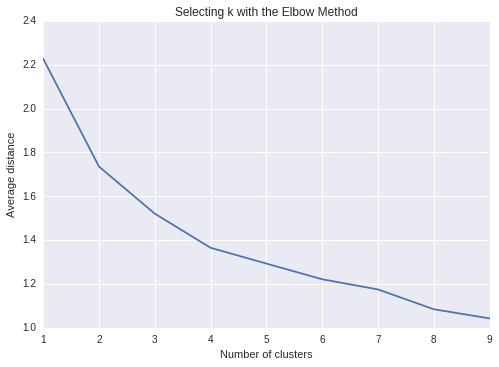

In [3]:
# k-means cluster analysis for 1-9 clusters
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(expla_train)
    clusassign=model.predict(expla_train)
    meandist.append(sum(np.min(cdist(expla_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / expla_train.shape[0])

"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sb

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

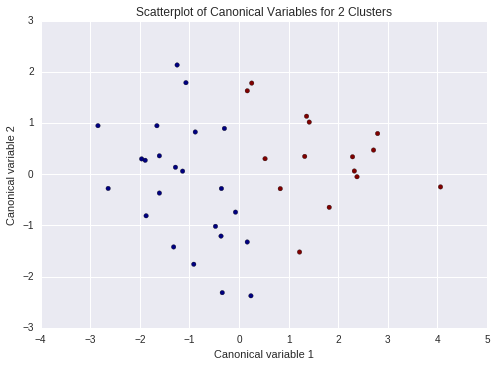

In [4]:
# Interpret 2 cluster solution
model3=KMeans(n_clusters=2)
model3.fit(expla_train)
clusassign=model3.predict(expla_train)

# plot clusters, using top two variables
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(expla_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_, cmap='jet')
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

In [5]:
"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
expla_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(expla_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(expla_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

0    23
1    15
Name: cluster, dtype: int64

In [6]:
"""
END multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""

# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print("Clustering variable means by cluster")
clustergrp

Clustering variable means by cluster


,index,Labor Participation,Unemployment2012,IncomePerCapita,avg_SAT_2012,Violent Crime rate,Property crime rate
cluster,,,,,,,
0,21.826087,-0.552969,0.608653,-0.020016,-0.502480,0.144860,-0.005353
1,32.133333,1.072885,-1.096743,0.003708,0.927394,-0.517102,-0.413081


In [7]:
# validate clusters in training data by examining cluster differences in %Obama>Romney using ANOVA

percent_obama = data_clean['Winner'].map({'Obama': 0, 'Romney': 1})
# split poll data into train and test sets
poll_train, poll_test = train_test_split(percent_obama, test_size=.25, random_state=123)
poll_train1=pd.DataFrame(poll_train)
poll_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(poll_train1, merged_train, on='index')
sub1 = merged_train_all[['Winner', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

poll_mod = smf.ols(formula='Winner ~ C(cluster)', data=sub1).fit()
print (poll_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 Winner   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.568
Date:                Wed, 24 Aug 2016   Prob (F-statistic):              0.219
Time:                        18:18:48   Log-Likelihood:                -26.717
No. Observations:                  38   AIC:                             57.43
Df Residuals:                      36   BIC:                             60.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.3913      0.105     

In [8]:
print ('means for Winner by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

print ('standard deviations for Winner by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

means for Winner by cluster
           Winner
cluster          
0        0.391304
1        0.600000
standard deviations for Winner by cluster
           Winner
cluster          
0        0.499011
1        0.507093


**p-value failed, also only two categories, no need to perform post hoc test
code below is for reference only**

>mc1 = multi.MultiComparison(sub1['Winner'], sub1['cluster'])
>res1 = mc1.tukeyhsd()
>print(res1.summary())